In [6]:
from tmc_analysis import *

In [7]:
configs = [
    IntersectionConfig(
        name="SR 544 & Charlotte",
        source="C:/Users/malex/OneDrive - Triune Infrastructure Group/Documents/Misc. Programs/SR 544 at Charlotte Rd (EXCEL EXPORT).xlsx",
        seasonal_factor=1.04,
        growth_factor=1.113,
        expansion_factor=1.89,
    ),
]

runner = BatchRunner(configs)
runner.load_all()                    # builds IntersectionData objects
reports = runner.build_reports()     # dict of report payloads keyed by name

reports["SR 544 & Charlotte"]["approach_summary"]  # access any table

charlotte = IntersectionData.from_workbook(
    "C:/Users/malex/OneDrive - Triune Infrastructure Group/Documents/Misc. Programs/SR 544 at Charlotte Rd (EXCEL EXPORT).xlsx",
    name="SR 544 & Charlotte",
)


In [8]:
reports["SR 544 & Charlotte"]["period_windows"]  # access any table

,Peak Start,Peak End,Peak Total
0,2025-08-26 07:15:00,2025-08-26 08:00:00,2675.0
1,2025-08-26 14:00:00,2025-08-26 14:45:00,2700.0
2,2025-08-26 15:30:00,2025-08-26 16:15:00,2921.0


In [9]:
reports["SR 544 & Charlotte"]["period_tables"]["PM"]  # access any table

Approach                   Northbound                                \
Movement                         Left     Through      Right U-Turn   
Peak 15-Min Volume          35.000000   66.000000  22.000000    0.0   
Counted Total Volume       111.000000  256.000000  78.000000    0.0   
Counted Heavy Vehicles       3.000000    4.000000   2.000000    0.0   
Heavy Vehicles Proportion    0.027027    0.015625   0.025641    NaN   
Peak Hour Factor             0.792857    0.969697   0.886364    NaN   
Seasonal Adjusted Volume   116.000000  267.000000  82.000000    0.0   
Projected Volume           129.000000  297.000000  91.000000    0.0   

Approach                   Southbound                            Eastbound  \
Movement                         Left     Through  Right U-Turn       Left   
Peak 15-Min Volume          48.000000   77.000000   5.00    0.0  26.000000   
Counted Total Volume       155.000000  292.000000  13.00    0.0  82.000000   
Counted Heavy Vehicles       2.000000   26.000000   0.00    0.0   1.000000   
Heavy Vehicles Proportion    0.012903    0.089041   0.00    NaN   0.012195   
Peak Hour Factor             0.807292    0.948052   0.65    NaN   0.788462   
Seasonal Adjusted Volume   162.000000  304.000000  14.00    0.0  86.000000   
Projected Volume           180.000000  338.000000  16.00    0.0  95.000000   

Approach                                                   Westbound  \
Movement                       Through      Right U-Turn        Left   
Peak 15-Min Volume          250.000000  25.000000    5.0   34.000000   
Counted Total Volume        897.000000  71.000000   12.0  110.000000   
Counted Heavy Vehicles       16.000000   5.000000    0.0    1.000000   
Heavy Vehicles Proportion     0.017837   0.070423    0.0    0.009091   
Peak Hour Factor              0.897000   0.710000    0.6    0.808824   
Seasonal Adjusted Volume    933.000000  74.000000   13.0  115.000000   
Projected Volume           1039.000000  83.000000   14.0  128.000000   

Approach                                                     
Movement                      Through       Right    U-Turn  
Peak 15-Min Volume         202.000000   42.000000  3.000000  
Counted Total Volume       717.000000  122.000000  5.000000  
Counted Heavy Vehicles      32.000000    1.000000  0.000000  
Heavy Vehicles Proportion    0.044630    0.008197  0.000000  
Peak Hour Factor             0.887376    0.726190  0.416667  
Seasonal Adjusted Volume   746.000000  127.000000  6.000000  
Projected Volume           830.000000  142.000000  6.000000

In [10]:
reports = runner.build_reports()
for name, payload in reports.items():
    safe_name = name.replace(" ", "_")
    export_report_to_excel(payload, f"output/{safe_name}_turning_movement_report.xlsx")

Wrote output\SR_544_&_Charlotte_turning_movement_report.xlsx


In [11]:
reports["SR 544 & Charlotte"].keys()

dict_keys(['metadata', 'period_windows', 'period_tables', 'approach_summary', 'phf_tables', 'intersection_obj'])

<Axes: title={'center': 'AM Peak Hour Stacked Movements'}, ylabel='Vehicles in Peak Hour'>

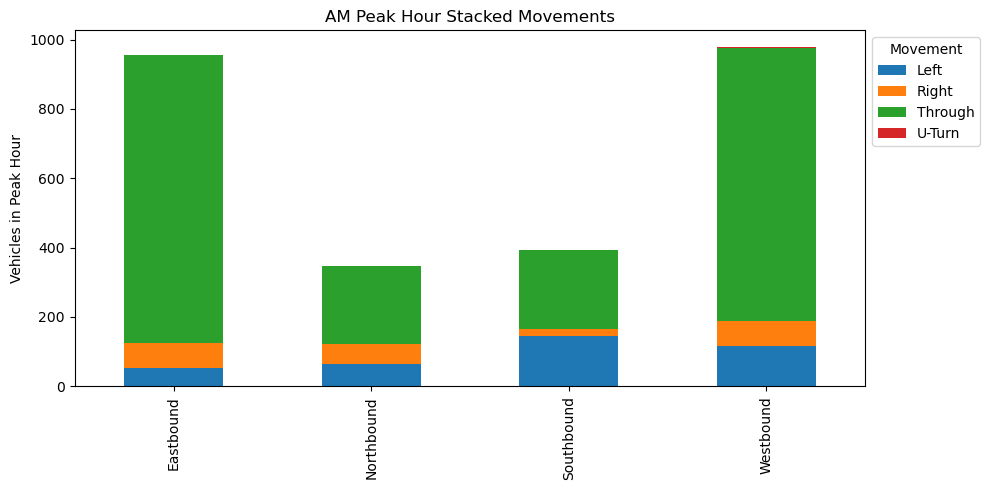

In [12]:
plot_peak_stacked_bars(reports["SR 544 & Charlotte"])

<Axes: title={'center': '15-minute Volumes (combined)'}, xlabel='Time', ylabel='Vehicles per 15 min'>

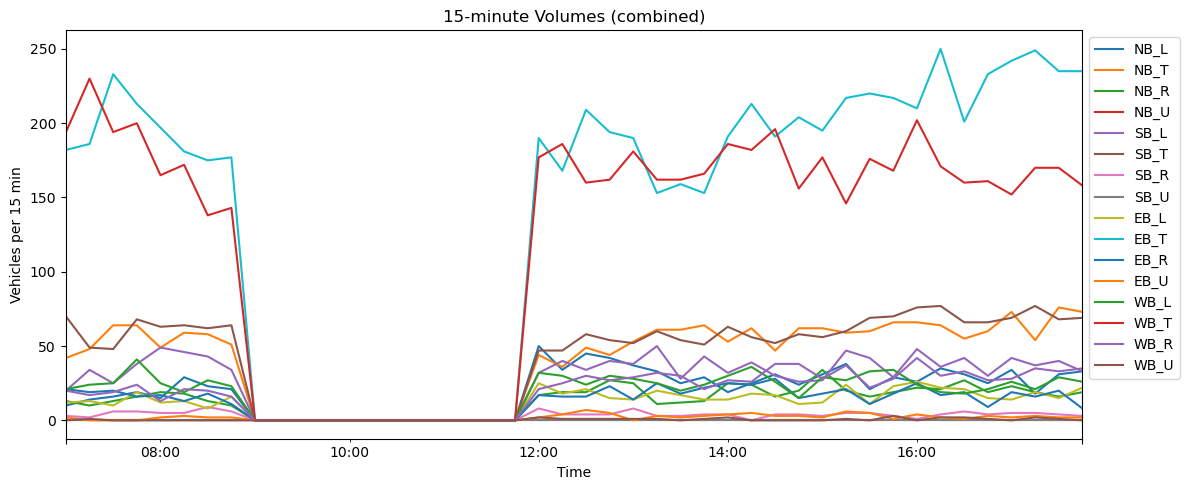

In [13]:
plot_movement_time_series(charlotte)

<Axes: title={'center': 'Heavy Vehicle Percentage (%)'}, xlabel='Movement', ylabel='Peak Period / Approach'>

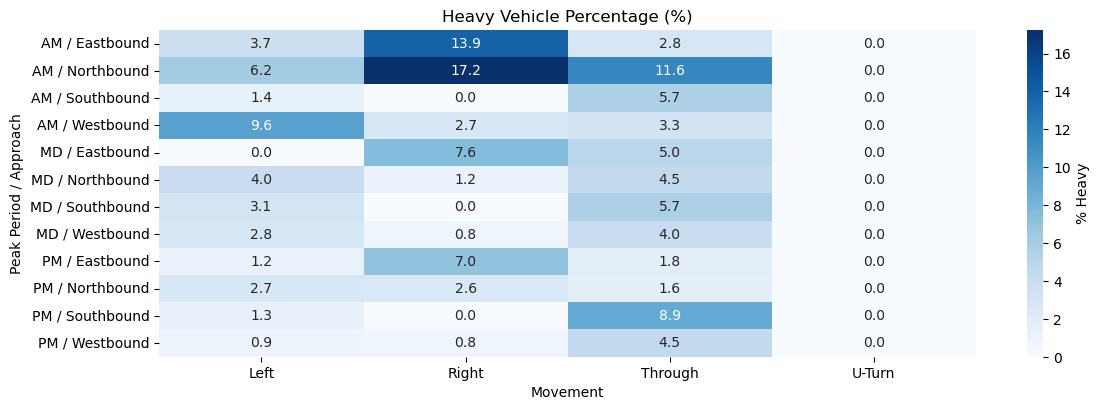

In [14]:
plot_heavy_percentage_heatmap(reports["SR 544 & Charlotte"])

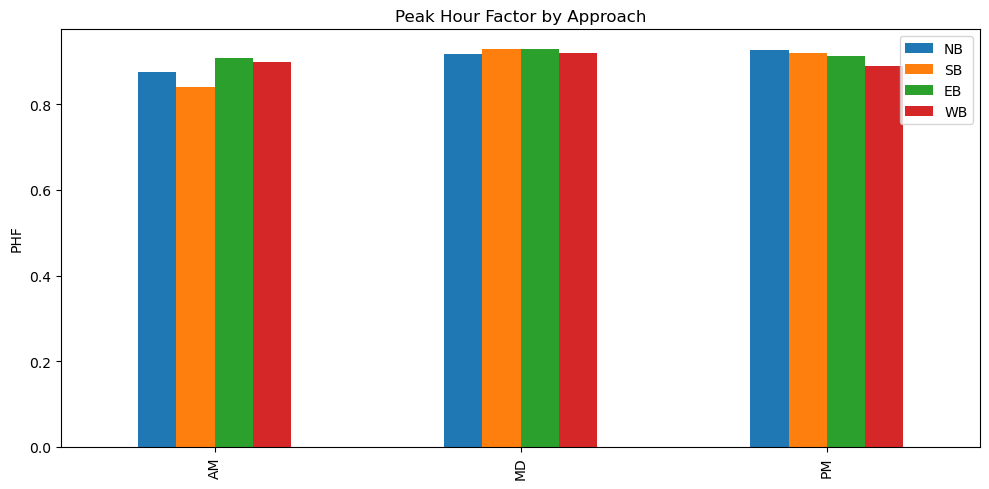

In [15]:
plot_phf_bars(charlotte)

<Axes: title={'center': 'AM Peak Hour Adjustment Comparison'}, ylabel='Vehicles (Peak Hour)'>

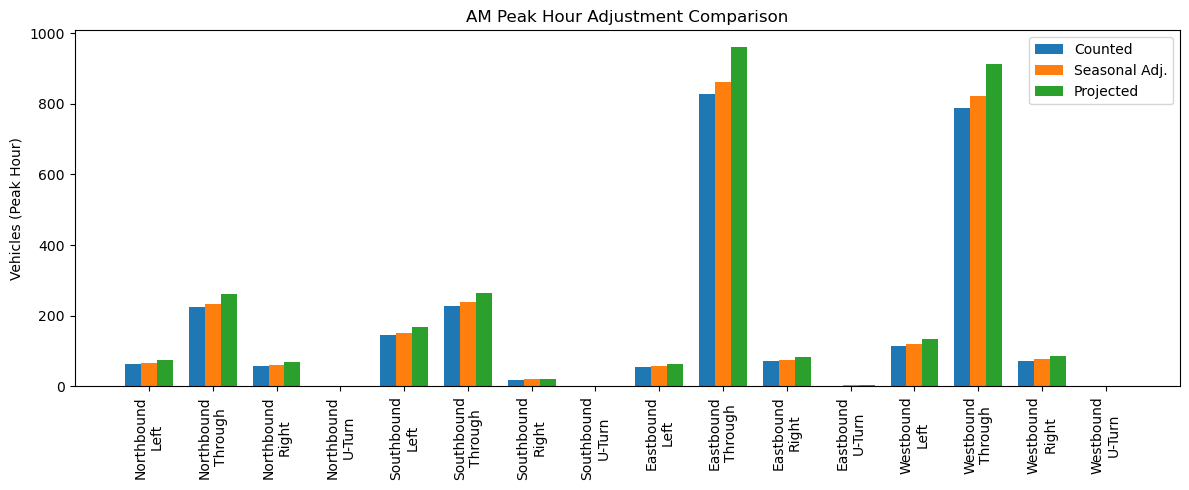

In [16]:
plot_adjusted_volume_comparison(reports["SR 544 & Charlotte"])